In [17]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [18]:
text = open('shakespeare.txt', 'r').read()
text = text.lower()
chars = sorted(list(set(text)))

In [91]:
stoi = {s: i for i,s in enumerate(chars)}
itos = {i: s for i,s in enumerate(chars)}
vsize = len(chars)
vsize

39

In [20]:
print(chars)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [90]:
data = torch.tensor([stoi[ch] for ch in text])
len(data)

1115394

In [92]:
print(''.join(itos[i.item()] for i in data[0:300]))

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:
we know't, we know't.

first citizen:
let us


In [78]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        self.igate = nn.Linear(input_size + hidden_size, hidden_size) # input
        self.fgate = nn.Linear(input_size + hidden_size, hidden_size) # forget
        self.ogate = nn.Linear(input_size + hidden_size, hidden_size) # output
        self.candidate = nn.Linear(input_size + hidden_size, hidden_size) # C-tilde
        self.h2o = nn.Linear(hidden_size, output_size) # map hidden layer to outputs
        
    def forward(self, x, hc):
        hidden, cell = hc

        combine = torch.cat((x, hidden), 1)

        i = self.sigmoid(self.igate(combine))
        f = self.sigmoid(self.fgate(combine))
        o = self.sigmoid(self.ogate(combine))
        # update cell state
        cand = self.tanh(self.candidate(combine))
        cell = cell * f + cand * i
        # return output, next hidden & new cell
        hidden = self.tanh(cell) * o
        # project output to desired outsize
        out = self.h2o(hidden)
        return out.squeeze(1), (hidden, cell)
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size, requires_grad=False), torch.zeros(1, self.hidden_size, requires_grad=False)

In [93]:
# initialize
lstm = LSTM(vsize, 100, vsize)
optim = torch.optim.Adam(lstm.parameters(), lr=0.01)

iters = 50_000
everyN = 2000
seqlen = 50
losses = []
# validation metrics
valid_cycle = 1000
correct = 0
# random sampling from data
idxs = torch.randint(0, 1_000_000, size=(iters,))

for i, idx in enumerate(idxs):
    # reset optimizer and hidden/cell states
    optim.zero_grad()
    hc = lstm.init_hidden()
    
    # Get x, y; encode, prepare output tensor
    x = data[idx : idx+seqlen]
    y = data[idx+1 : idx+seqlen+1]
    x_enc = F.one_hot(x, vsize).view(seqlen, 1, vsize).float()
    out = torch.zeros((seqlen, vsize))
    
    # Forward propagation
    for j, ch in enumerate(x_enc):
        out[j], hc = lstm.forward(ch, hc)        
    
    loss = F.cross_entropy(out, y)
    
    if i % everyN == 0:
        losses.append(loss.item())
        print(f"i: {i} \tidx: {idx} \tLoss: {loss} \tOutMax: {torch.max(out)} \tArgMax: {torch.argmax(out[seqlen-1])}")
        # Max and ArgMax represent confidence and character choice
        
    # Accuracy check
    choice = torch.argmax(out[seqlen-1])
    if choice == y[seqlen-1]:
        correct += 1
        
    if i % valid_cycle == 0 and i > 0:
        print(f"i: {i} \tAccuracy: {correct / valid_cycle}")
        correct = 0
    
    # Backpropagation
    loss.backward()
    optim.step()
    

i: 0 	idx: 357201 	Loss: 3.662724494934082 	OutMax: 0.1191447451710701 	ArgMax: 19
i: 1000 	Accuracy: 0.366
i: 2000 	idx: 669762 	Loss: 1.9900102615356445 	OutMax: 7.8255181312561035 	ArgMax: 26
i: 2000 	Accuracy: 0.413
i: 3000 	Accuracy: 0.453
i: 4000 	idx: 541448 	Loss: 2.003615379333496 	OutMax: 9.443570137023926 	ArgMax: 1
i: 4000 	Accuracy: 0.424
i: 5000 	Accuracy: 0.474
i: 6000 	idx: 369231 	Loss: 1.8407559394836426 	OutMax: 9.98324203491211 	ArgMax: 1
i: 6000 	Accuracy: 0.508
i: 7000 	Accuracy: 0.492
i: 8000 	idx: 632351 	Loss: 1.309738278388977 	OutMax: 9.508337020874023 	ArgMax: 32
i: 8000 	Accuracy: 0.512
i: 9000 	Accuracy: 0.504
i: 10000 	idx: 230936 	Loss: 2.0606513023376465 	OutMax: 9.130377769470215 	ArgMax: 26
i: 10000 	Accuracy: 0.52
i: 11000 	Accuracy: 0.5
i: 12000 	idx: 25480 	Loss: 1.6349611282348633 	OutMax: 13.04227066040039 	ArgMax: 15
i: 12000 	Accuracy: 0.515
i: 13000 	Accuracy: 0.528
i: 14000 	idx: 567873 	Loss: 1.5604262351989746 	OutMax: 12.866466522216797 	A

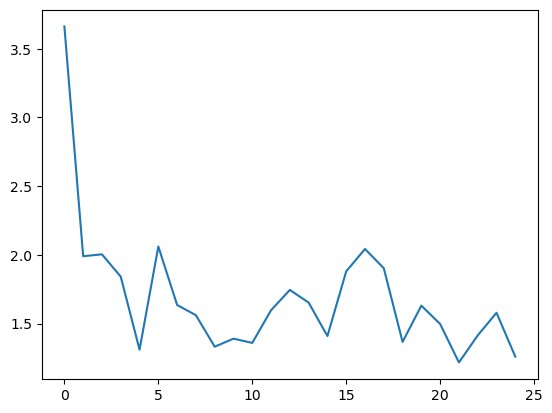

In [94]:
plt.plot(losses)
plt.show()

In [99]:
with torch.no_grad():
    char = 13
    hc = lstm.init_hidden()
    
    gen = ""
    gen += str(itos[char])
    
    for i in range(2000):
        char_enc = F.one_hot(torch.tensor([char]), vsize).view( 1 , vsize).float()
        preds, hc = lstm.forward(char_enc, hc)
        
        distr = torch.distributions.Categorical(probs=F.softmax(preds, dim=1))
        choice = distr.sample()

        char = choice
        gen += str(itos[char.item()])


In [100]:
print(gen)

as thou art with
the life:
gretidoung, my lord, you steil think as ye soul:
i false. well, thoubto crace the urhbier, all derial:
ongur thand my camently:
sapent, somethit o, what yet me, by well dispabtess in is friar.
bawding thou do.

carings:
or: hure, it was the you
are gives peter, maly your marcius.

, suffing.

all:
thou ww call is enchar:
what hast thou thank your margaret:
hood ii:
marry? for for thing actiperur,
king!
sine, and gracious by no, belatter!

juliet:
doth gods; abour of, commew, norturance is peter in lows,
o' is sent of jung-words, i bases, cannot be preseaps
and vithour and his vaughter and not masting:
too wast have i chatter i came in the mindered.

saudys:
stop himself shaughting of once me down and trease:
givery of prese, he spervant mes lies.

romeo:
let them ear of bupes door, as thou make of glasted lepterer; madam;
dest be course with with be indeed,
seaph did sung laese do clifford's tranio,
but death touch no warwick's to thought of soly do replet as